In [4]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import random
import math

# Define the Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
I = np.eye(2, dtype=complex)



def chain_builder(N, rho):
    """
    having chain be a numpy array that the first column is the ferminonic number of the pair and the second column 
    is the Majorana operator which can be assigned randomly at contact to simulate quantum randomness.
    third column is the pair index
    """
    if N % 2 != 0:
        raise ValueError("N must be even for a Majorana chain.")
    chain = np.full((N* rho, 3), -10) 
    for i in range(N):
        chain[i * rho][0] = 1 # initially all pairs have fermion number 1
        chain[i * rho][1] = 47
        chain[i * rho][2] = int(i/2) # index for pair (i,j), where i<j, using i to denote the Majorana j is paired with.
        # chain[i * rho][3] = i # Majorana index
    return chain

def hopping(chain_):
    chain = chain_.copy()
    N = len(chain)
    index = np.where(chain[:,1] == 47)[0] 
    Nt = len(index)  # Number of Majoranas at time step t
    # i =random.randint(0, N-1)
    for k in range(Nt):
        index = np.where(chain[:,1] == 47)[0] 
        i = random.choice(index)
        hope_direction = np.random.choice([-1, 1])
        if chain[i][0] == -10: #if the site is empty
            pass

        elif chain[(i+hope_direction) % N][0] == -10: #if the site to arrive is empty
            chain[(i+hope_direction) % N][0] = chain[i][0]
            chain[i][0] = -10
            chain[(i+hope_direction) % N][1] = chain[i][1]
            chain[i][1] = -10
            chain[(i+hope_direction) % N][2] = chain[i][2]
            chain[i][2] = -10
            # chain[(i+hope_direction) % N][3] = chain[i][3]
            # chain[i][3] = -10
            

        elif chain[(i+hope_direction) % N][2] == chain[i][2]:  #if paired under periodic boundary condition
            # if chain[i][0] == 0 and chain[(i+hope_direction) % N][0] == 0:
            #     chain[i][2] = -10
            #     chain[(i+hope_direction) % N][2] = -10
            pass # do nothing, the Majorana operators are already paired
        
        else:
            #if hope_direction < 0:
            # get the index of paired Majorana
            rows_i = np.where(chain[:, 2] == chain[i][2])[0]
            rows = np.where(chain[:, 2] == chain[(i+hope_direction) % N][2])[0]
            outside_index_i = [x for x in rows_i if x != i][0]
            outside_index = [x for x in rows if x != (i+hope_direction)%N][0]

            # calculate the ferminon number of new arcs
            ferminon_number =  np.random.choice([0, 1])
            n_sum = chain[i][0] + chain[(i+hope_direction) % N][0]

            
            
            chain[i][0] = ferminon_number
            chain[(i+hope_direction) % N][0] = ferminon_number
            chain[outside_index_i][0] = (n_sum-ferminon_number) % 2 # conservation of ferminon number
            chain[outside_index][0] = (n_sum-ferminon_number) % 2

            # update the pairing index
            
            pair_index = chain[(i+hope_direction) % N][2]
            pair_index_i = chain[i][2]
            min_index = min(pair_index, pair_index_i)
            max_index = max(pair_index, pair_index_i)

            if  i == min(i, (i+hope_direction) % N, outside_index_i, outside_index) or (i+hope_direction) % N == min(i, (i+hope_direction) % N, outside_index_i, outside_index):
                chain[i][2] = min_index
                chain[(i+hope_direction) % N][2] = min_index
                chain[outside_index_i][2] = max_index
                chain[outside_index][2] = max_index
            else:
                chain[i][2] = max_index
                chain[(i+hope_direction) % N][2] = max_index
                chain[outside_index_i][2] = min_index
                chain[outside_index][2] = min_index
            """       
            else:
                
                # get the index of pairing Majorana
                rows, cols = np.where(chain == chain[i][2])
                rows_right, cols_left = np.where(chain == chain[(i+hope_direction) % N][2])
                outside_index = [x for x in rows if x != i][0]
                right_outside_index = [x for x in rows_right if x != (i+hope_direction)%N][0]

                # calculate the ferminon number of new arcs
                chain[i][1] = np.random.choice([0, 1])
                chain[(i+hope_direction) % N][1] = np.random.choice([0, 1])
                ferminon_number = (chain[i][1] + chain[(i+hope_direction) % N][1]) %2
                
                chain[i][0] = ferminon_number
                chain[(i+hope_direction) % N][0] = ferminon_number
                chain[outside_index][0] = (ferminon_number+1) % 2 # conservation of ferminon number
                chain[right_outside_index][0] = (ferminon_number+1) % 2

                # update the pairing index
                pair_index_right = chain[(i+hope_direction) % N][2]
                pair_index_left = chain[i][2]
                if  i == min(i, (i+hope_direction) % N, outside_index, right_outside_index) or (i+hope_direction) % N == min(i, (i+hope_direction) % N, outside_index, right_outside_index):
                    chain[i][2] = pair_index_left
                    chain[(i+hope_direction) % N][2] = pair_index_left
                    chain[outside_index][2] = pair_index_right
                    chain[right_outside_index][2] = pair_index_right
                else:
                    chain[i][2] = pair_index_right
                    chain[(i+hope_direction) % N][2] = pair_index_right
                    chain[outside_index][2] = pair_index_left
                    chain[right_outside_index][2] = pair_index_left

                """
    return chain
    

    
def worldline(chain):
    """
    Generates a worldline representation of the Majorana chain.
    The function returns a list of pairs (Majorana index, fermion number).
    """
    index = np.where(chain[:, 1] == 47)[0]  # Get indices of Majoranas that are present
    wl = np.zeros((1, len(index)), dtype=object)  # Initialize an empty list for the worldline
    for i in index:
        wl[0][chain[i][3]] = i  # position of ith particle
    return wl
    
def evolution(chain, t, plot=False):
    """
    Simulates the evolution of the Majorana chain over time t.
    The function modifies the chain in place.
    """
    if plot: 
        N = len(np.where(chain[:, 1] == 47)[0])  # Number of Majoranas
        history = np.empty((t, N), dtype=object)  # Initialize history for plotting
        for i in range(t):
            chain = hopping(chain)
            wl = worldline(chain)
            history[i,:] = wl.reshape(-1)
        return chain, history
    else:
        for _ in range(t):
            chain = hopping(chain)
        return chain

def calculate_pair_distances(chain):
    """
    Computes the arc length of Majorana pairs
    
    Returns:
      pair_data: a list of tuples (pair_index, distance)
      distance_counts: a dictionary mapping distance -> count of pairs with that distance
    """
    pair_positions = {}
    # Loop over each row in the chain and record its index based on its pairing index (third column)
    for i, row in enumerate(chain):
        pair_idx = row[2]
        if pair_idx is -10:
            pass
        if pair_idx in pair_positions:
            pair_positions[pair_idx].append(i)
        else:
            pair_positions[pair_idx] = [i]
    
    pair_data = []    
    distance_counts = {} 
    L = len(chain)
    for pair_idx, positions in pair_positions.items():
        if len(positions) == 2:
            d = min ( abs(positions[1] - positions[0]) , abs(positions[1]-positions[0]+ L),   abs(positions[1]-positions[0]- L) ) # Calculate the distance considering periodic boundary conditions
            pair_data.append((pair_idx, d))
            distance_counts[d] = distance_counts.get(d, 0) + 1
        else:
            # If there are not exactly two entries for a pair index, issue a warning.
            print(f"Warning: Pair index {pair_idx} appears {len(positions)} times (expected 2).")
    
    return pair_data, distance_counts
     

def S_A(chain, R):
    """
    Calculates entanglement entropy S_A based on the distances of Majorana pairs.
    
    Returns:
      S_A: float
          The computed value of S_A.
    """
    S_A = 0.0
    x0 = int((len(chain)-R)/2)
    for i in range(x0, x0+R):
        if chain[i][0] != -10:

            ids = np.where(chain[:, 2] == chain[i][2])[0]
            other_majorana = [x for x in ids if x != i][0]
            if  other_majorana < x0 or other_majorana > x0 + R:  # Check if the paired Majorana is outside the region A
            # Check if the pair exists
                S_A += 1
            # else:
            #     S_A += 1/2
    return S_A

def chain_compact(chain):
    """
    Converts the Majorana chain into a compact representation.
    
    Returns:
      compact_chain: numpy array
          A 2D array with the first column as Majorana indices and the second column as fermion numbers.
    """
    N = chain.shape[0]
    compact_chain = np.zeros((N, 2), dtype=int)
    index = np.where(chain[:, 1] == 47)[0]  # Get indices of Majoranas that are present
    for i in index:
        compact_chain[i][0] = chain[i][0]  # Majorana index
        compact_chain[i][2] = chain[i][2]   # Fermion number
    return compact_chain
        

<>:176: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:176: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
/var/folders/b0/yd0t1s1d3csclx8j2np0lfvc0000gn/T/ipykernel_35848/602659404.py:176: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  if pair_idx is -10:


In [3]:
import time
start = time.time()

chain = chain_builder(1000, 3)   
chain_1 = evolution(chain, 10000)

end = time.time()
print(f"Chain built in {end - start:.2f} seconds.")

chain_t = chain_compact(chain_1)

pair_data1, distance_counts1 = calculate_pair_distances(chain_t)
distances1 = list(distance_counts1.keys())
counts1 = [distance_counts1[d] for d in distances1]
plt.scatter(distances1, counts1, label='Pair Distances', color='blue')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.title('Pair Distances in Majorana Chain')
plt.legend()
plt.grid()
plt.show()


KeyboardInterrupt: 

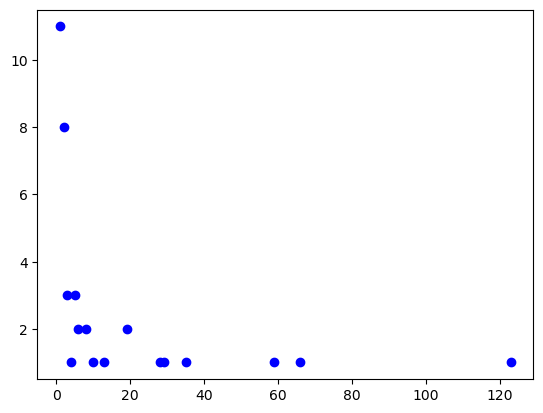

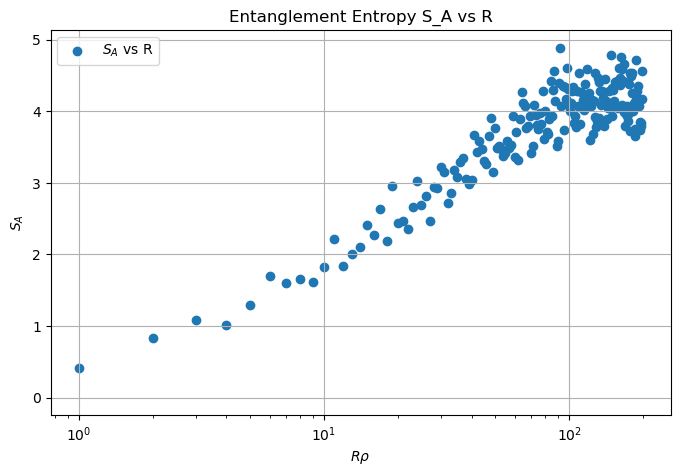

In [2]:
chain = chain_builder(80, 4)   
chain_t = evolution(chain, 8000)

pair_data1, distance_counts1 = calculate_pair_distances(chain_t)
distances1 = list(distance_counts1.keys())
counts1 = [distance_counts1[d] for d in distances1]
plt.scatter(distances1, counts1, label='Pair Distances', color='blue')
plt.show()

x =[]
y= np.zeros(200, dtype=float)

for i in range(200):
    R = i
    x.append(R)
    for t in range(1, 200):
        chain_t = evolution(chain_t, t) 
        
        S_A_value = S_A(chain_t, R)
        
        y[i] += S_A_value
y= y/ 100  # Average over time steps
# y = np.log(y)
# x = np.log(x)
plt.figure(figsize=(8, 5))
plt.scatter(x, y, label=r'$S_A$ vs R')
plt.xlabel(r'$R \rho$')
plt.ylabel(r'$S_A$')
plt.xscale('log')
# plt.yscale('log')
plt.title("Entanglement Entropy S_A vs R")
plt.grid(47)
plt.legend()
plt.show()


In [5]:
# to fit entanglement entropy
def S_A_fit(x, a):
    return a* np.log(0.25* x)
popt, pcov = curve_fit(S_A_fit, x[1:], y[1:] )
print("Fitted parameters:", popt)
print("Covariance of the parameters:", pcov)

Fitted parameters: [1.2193417]
Covariance of the parameters: [[0.00015109]]


[[1 True 0 0]
 [None None None None]
 [1 True 0 1]
 [None None None None]
 [1 True 1 2]
 [None None None None]
 [1 True 1 3]
 [None None None None]]
[[np.int64(1) np.int64(2) np.int64(5) np.int64(6)]
 [np.int64(1) np.int64(3) np.int64(5) np.int64(6)]
 [np.int64(0) np.int64(2) np.int64(5) np.int64(6)]
 [np.int64(1) np.int64(3) np.int64(5) np.int64(7)]
 [np.int64(2) np.int64(4) np.int64(5) np.int64(0)]
 [np.int64(3) np.int64(4) np.int64(5) np.int64(1)]
 [np.int64(3) np.int64(4) np.int64(5) np.int64(2)]
 [np.int64(3) np.int64(4) np.int64(6) np.int64(2)]
 [np.int64(3) np.int64(5) np.int64(7) np.int64(2)]
 [np.int64(4) np.int64(6) np.int64(0) np.int64(1)]
 [np.int64(5) np.int64(6) np.int64(0) np.int64(2)]
 [np.int64(5) np.int64(6) np.int64(7) np.int64(3)]
 [np.int64(5) np.int64(6) np.int64(7) np.int64(4)]
 [np.int64(5) np.int64(6) np.int64(7) np.int64(4)]
 [np.int64(5) np.int64(6) np.int64(0) np.int64(4)]
 [np.int64(5) np.int64(7) np.int64(1) np.int64(4)]
 [np.int64(6) np.int64(0) np.int64(

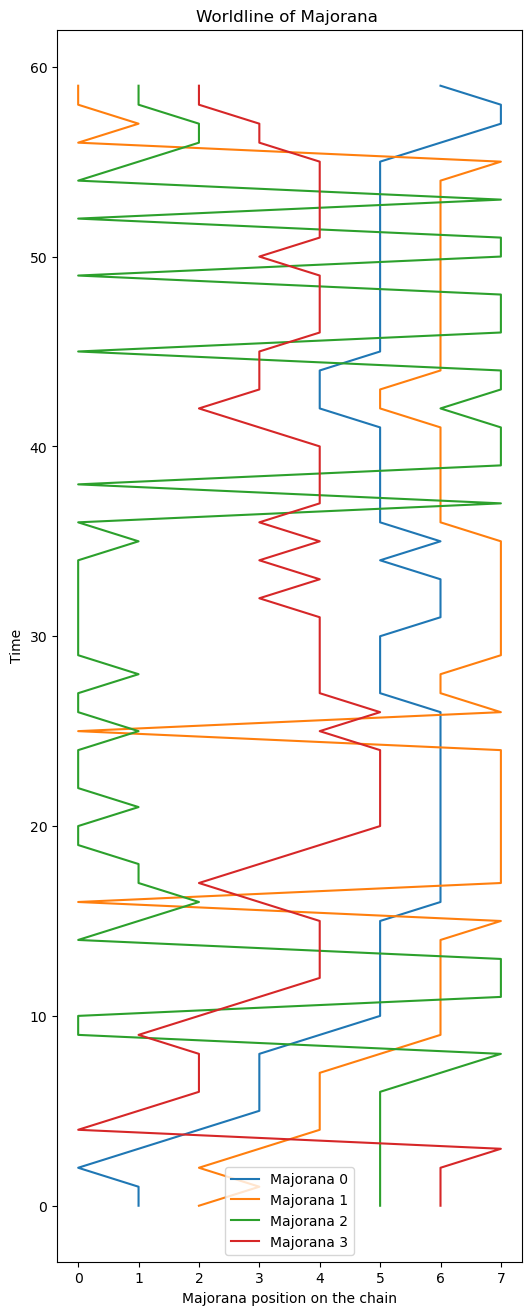

In [6]:
chain = chain_builder(4, 2)   
print(chain)
chain, hist = evolution(chain, 60, plot=47)
print(hist)
t = np.arange(0, len(hist))
plt.figure(figsize=(6, 16))
plt.plot(hist[:,0], t,  label='Majorana 0')
plt.plot( hist[:,1], t, label='Majorana 1')
plt.plot( hist[:,2], t, label='Majorana 2')
plt.plot(hist[:,3], t, label='Majorana 3')
plt.xlabel('Majorana position on the chain')
plt.ylabel('Time')
plt.title('Worldline of Majorana ')
plt.savefig('worldline_majorana.png')
plt.legend()
plt.show()


In [10]:
chain = chain_builder(2000, 4)

chain1 = evolution(chain, t =5000)
chain2 = evolution(chain1, t = 8000)
chain3 = evolution(chain2, t = 8000)
chain4 = evolution(chain3, t = 30000)


print(chain)
pair_data1, distance_counts1 = calculate_pair_distances(chain)
pair_data2, distance_counts2 = calculate_pair_distances(chain1)
pair_data3, distance_counts3 = calculate_pair_distances(chain2)
pair_data4, distance_counts4 = calculate_pair_distances(chain3)
pair_data5, distance_counts5 = calculate_pair_distances(chain4)


[[1 True 0]
 [None None None]
 [None None None]
 ...
 [None None None]
 [None None None]
 [None None None]]


In [3]:
pair_data1, distance_counts1 = calculate_pair_distances(chain)
pair_data2, distance_counts2 = calculate_pair_distances(chain1)
pair_data3, distance_counts3 = calculate_pair_distances(chain2)
pair_data4, distance_counts4 = calculate_pair_distances(chain3)
pair_data5, distance_counts5 = calculate_pair_distances(chain4)

distances1 = list(distance_counts1.keys())
counts1 = [distance_counts1[d] for d in distances1]
distances2 = list(distance_counts2.keys())
counts2 = [distance_counts2[d] for d in distances2]
distances3 = list(distance_counts3.keys())
counts3 = [distance_counts3[d] for d in distances3]
distances4 = list(distance_counts4.keys())
counts4 = [distance_counts4[d] for d in distances4]
# distances5 = list(distance_counts5.keys())
# counts5 = [distance_counts5[d] for d in distances5]

# def logy(x):
#     return -0.267 -2 *x
# x_line = np.linspace(0, 4, 1000)
# y_line = logy(x_line)
# x = np.log10(np.array(distances1))
# y = np.log10(np.array(counts1)/5000)
# plt.rcParams['text.usetex'] = False
# fig = plt.figure(figsize=(8, 5))
# plt.plot(x_line, y_line, color='black', label='y = -0.267 - 2x')

# plt.scatter(x, y, color= 'blue', s=10)  # adjust size if needed
plt.scatter(distances1, counts1, color= 'red', s=10)  # adjust size if needed
plt.scatter(distances2, counts2, color= 'blue', s=10)  # adjust size if needed
plt.scatter(distances3, counts3, color= 'green', s=10)  # adjust size if needed
plt.scatter(distances4, counts4, color= 'purple', s=10)  # adjust size if needed
# plt.scatter(distances5, counts5, color= 'orange', s=10)  # adjust size if needed
plt.xlabel(r'$\rho \ell$')
plt.ylabel(r'P($\ell$)')
# plt.xlim(0, 50)
# plt.ylim(0, 75)
plt.yscale('log')
plt.xscale('log')
plt.title("Correlation: Distance vs Number of Majorana Pairs")
plt.grid(47)
plt.show()

NameError: name 'chain' is not defined

In [4]:
from scipy.optimize import curve_fit
def func(x, a):
    return a/ (0.25*x)** (2)

index = np.where(np.array(counts4) > 1 )[0]
xdata = np.array([ distances4[i] for i in index ])
ydata = np.array( [counts4[i] for i in index] )/len(index)
popt, pcov = curve_fit(func, xdata, ydata)
print("Fitted parameter:", popt)
print("Covariance of the parameters:", pcov)


NameError: name 'counts4' is not defined

In [28]:
counts4

[24,
 323,
 2,
 110,
 66,
 9,
 28,
 12,
 2,
 152,
 1,
 42,
 7,
 16,
 20,
 8,
 1,
 46,
 12,
 3,
 2,
 7,
 1,
 1,
 3,
 1,
 1,
 7,
 1,
 5,
 3,
 9,
 1,
 3,
 2,
 1,
 1,
 6,
 3,
 3,
 3,
 2,
 1,
 1,
 1,
 3,
 1,
 4,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

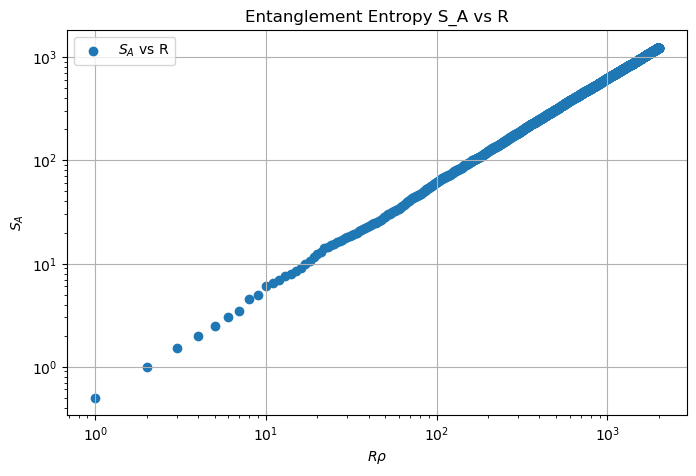

In [35]:

rho = 4
x =[]
y=[]

for i in range(1, 2000):
    R = i
    S_A_value = S_A(chain4, R)
    x.append(R)
    y.append(S_A_value)
# y = np.log(y)
# x = np.log(x)
plt.figure(figsize=(8, 5))
plt.scatter(x, y, label=r'$S_A$ vs R')
plt.xlabel(r'$R \rho$')
plt.ylabel(r'$S_A$')
plt.xscale('log')
plt.yscale('log')
plt.title("Entanglement Entropy S_A vs R")
plt.grid(47)
plt.legend()
plt.show()

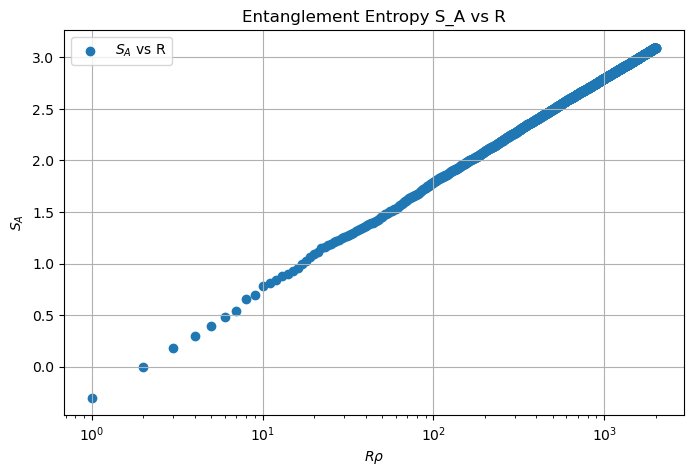

In [40]:
y = 10**y
y1 = np.log10(y)
# x = np.log(x)
plt.figure(figsize=(8, 5))
plt.scatter(x, y1, label=r'$S_A$ vs R')
plt.xlabel(r'$R \rho$')
plt.ylabel(r'$S_A$')
plt.xscale('log')
# plt.yscale('log')
plt.title("Entanglement Entropy S_A vs R")
plt.grid(47)
plt.legend()
plt.show()

In [41]:
# to fit entanglement entropy
def S_A_fit(x, a):
    return a* np.log(0.25* x)
popt, pcov = curve_fit(S_A_fit, x, y1 )
print("Fitted parameters:", popt)
print("Covariance of the parameters:", pcov)

Fitted parameters: [0.50771147]
Covariance of the parameters: [[8.32837427e-08]]
